In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math,copy,time

from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

In [2]:
class Encoder_Decoder(nn.Module):
    """
    采用encoder-decoder结构，将输入序列映射到一个z(z_1,z_2...z_n)
    对于编码得到的z，decoder解码生成一个值，直到生成所有序列y
    过程是自回归的，即生成下一个符号需要将上一个生成的符号作为附加输入
    """
    def __init__(self,encoder,decoder,src_embed,tgt_embed,generator):
        super(Encoder_Decoder,self).__init__()
        self.encoder=encoder
        self.decoder=decoder
        self.src_embed=src_embed
        self.tgt_embed=tgt_embed
        self.generator=generator
    def forward(self,src,tgt,src_mask,tgt_mask):
        return self.decode(self.encode(src,src_mask),
                           src_mask,
                           tgt,
                           tgt_mask)
    def encode(self,src,src_mask):
        return self.encoder(self.src_embed(src),src_mask)
    def decode(self,memory,src_mask,tgt,tgt_mask):
        return self.decoder(self.tgt_embed(tgt),memory,src_mask,tgt_mask)
class Generator(nn.Module):
    """
    定义标准的linear+softmax的步骤
    """
    def __init__(self,d_model,vocab):
        super(Generator,self).__init__()
        self.proj=nn.Linear(d_model,vocab)
    def forward(self,x):
        return F.log_softmax(self.proj(x),dim=-1)

In [12]:
def clones(module,N):
    """
    克隆N个相同的层
    """
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])
class Encoder(nn.Module):
    def __init__(self,layer,N):
        super(Encoder,self).__init__()
        self.layers=clones(layer,N)
        self.norm=LayerNorm(layer.size)
    def forward(self,x,mask):
        for layer in self.layers:
            x=layer(x,mask)
        return self.norm(x)

In [4]:
class EncoderLayer(nn.Module):
    """
    self-att + ff
    """
    def __init__(self,size,self_attn,feed_forward,dropout):
        super(EncoderLayer,self).__init__()
        self.self_attn=self_attn
        self.feed_forward=feed_forward
        self.sublayer = clones(SublayerConnection(size,dropout),2)
        self.size=size
    def forward(self,x,mask):
        x=self.sublayer[0](x,lambda x:self.self_attn(x,x,x,mask))
        return self.sublayer[1](x,self.feed_forward)


In [11]:
class SublayerConnection(nn.Module):
    """
    residual by layer norm
    """
    def __init__(self,size,dropout):
        super(SublayerConnection,self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
    def forward(self,x,sublayer):
        return x+self.dropout(sublayer(self.norm(x)))

$$Attention(Q,K,V)=softmax(\frac{QK^T}{\sqrt(d_k)})V$$

In [8]:
def attention(query,key,value,mask=None,dropout=None):
    """
    scaled-dot-product-attn
    query[batch_size,heads,max_seq_len,d_q]
    key[batch_size,heads,max_seq_len,d_k]
    value[batch_size,heads,max_seq_len,d_v]
    d_v=d_k=d_q
    Q=K=V
    """
    """
    Q*K:
        (batch_size,heads,max_seq_len,d_k)*(batch_size,heads,d_k,max_seq_len)
        =(batch_size,heads,max_seq_len,max_seq_len)
    """
    d_k=query.size(-1)
    scores = torch.matmul(query,key.transpose(-2,-1))/math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0,-1e9)
    p_attn = F.softmax(scores,dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn,value),p_attn
class Multi_Head_Attention(nn.Module):
    def __init__(self,h,d_model,dropout=0.1):
        super(Multi_Head_Attention,self).__init__()
        assert d_model%h==0,"head is not a multiple of the number of the in_features"
        self.d_k=d_model//h
        self.h=h
        self.linears=clones(nn.Linear(d_model,d_model),4)
        self.attn = None
        self.dropout=nn.Dropout(dropout)
    def forward(self,query,key,value,mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1)
        n_batches = query.size(0)
        query,key,value = [
                            linear(x).view(n_batches,-1,self.h,self.d_k).transpose(1,2)
                            for linear,x in zip(self.linears,(query,key,value))
                          ]
        x,self.attn =  attention(query,key,value,mask=mask,dropout=self.dropout)
        x=x.transpose(1,2).contiguous().view(n_batches,-1,self.h*self.d_k)
        return self.linears[-1](x)


1 <class 'torch.Tensor'> torch.Size([1, 20, 20])


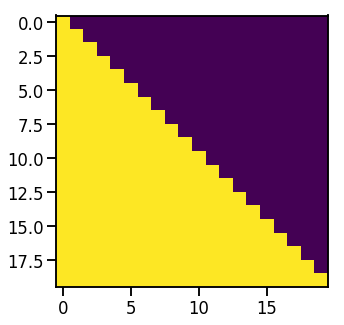

In [51]:
def subsequent_mask(size):
    "mask out subsequent positions"
    attn_shape = (1,size,size)
    subsequent_mask = np.triu(np.ones(attn_shape),k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask)==0
a=subsequent_mask(20)
plt.figure(figsize=(5,5))
plt.imshow(a[0])
print(len(a),type(a),a.size())

In [14]:
class LayerNorm(nn.Module):
    def __init__(self,feature,eps=1e-6):
        super(LayerNorm,self).__init__()
        self.r_2=nn.Parameter(torch.ones(feature))
        self.b_2=nn.Parameter(torch.zeros(feature))
        self.eps=eps
    def forward(self,x):
        mean=x.mean(-1,keepdim=True)
        std=x.std(-1,keepdim=True)
        return self.r_2*(x-mean)/(std+self.eps)+self.b_2

$$FFN(x)=max(0,xW_1+b_1)W_2+b_2$$

In [17]:
class PositionwiseFeedForard(nn.Module):
    '''
    FFN equation
    d_model=512
    d_ff=2048
    '''
    def __init__(self,d_model,d_ff,dropout=0.1):
        super(PositionwiseFeedForard,self).__init__()
        self.w_1 = nn.Linear(d_model,d_ff)
        self.w_2 = nn.Linear(d_ff,d_model)
        self.dropout=nn.Dropout(dropout)
    def forward(self,x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [28]:
class Embedding(nn.Module):
    def __init__(self,d_model,vocab):
        super(Embedding,self).__init__()
        self.lookuptable=nn.Embedding(vocab,d_model)
        self.d_model=d_model
    def forward(self,x):
        return self.lookuptable(x)*math.sqrt(self.d_model)

In [29]:
'''
Transformer 没有使用RNN、CNN便失去了输入的位置信息，而位置信息中也包含了许多信息
后期使用的位置信息包含两种，一是绝对位置、而是相对位置
绝对位置决定单词在一个序列中的第几个位置
相对位置决定了序列的流向
使用正弦余弦函数进行位置编码
'''
class PositionalEncoding(nn.Module):
    def __init__(self,d_model,dropout,max_len=5000):
        super(PositionalEncoding,self).__init__()
        self.dropout=nn.Dropout(dropout)
        
        pe=torch.zeros(max_len,d_model)
        position=torch.arange(0,max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0,d_model,2)*-(math.log(10000.0)/d_model))
        pe[:,0::2] = torch.sin(position*div_term)
        pe[:,1::2] = torch.cos(position*div_term)
        pe=pe.unsqueeze(0)
        self.register_buffer('pe',pe)
    def forward(self,x):
        x=x+Variable(self.pe[:,:x.size(1)],requires_grad=False)
        return self.dropout(x)


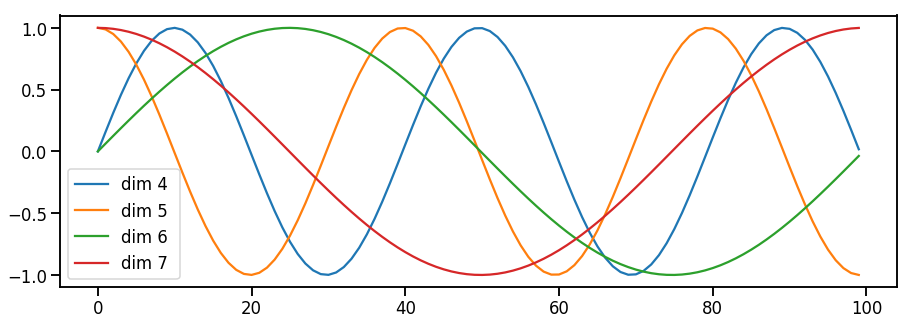

In [30]:
plt.figure(figsize=(15,5))
pe=PositionalEncoding(20,0)
y=pe.forward(Variable(torch.zeros(1,100,20)))
plt.plot(np.arange(100),y[0,:,4:8].data.numpy())
plt.legend(["dim %d " %p for p in range(4,8)])

In [31]:
class Decoder(nn.Module):
    def __init__(self,layer,N):
        super(Decoder,self).__init__()
        self.layers=clones(layer,N)
        self.norm=LayerNorm(layer.size)
    def forward(self,x,memory,src_mask,tgt_mask):
        for layer in self.layers:
            x=layer(x,memory,src_mask,tgt_mask)
        return self.norm(x)

In [32]:
class DecoderLayer(nn.Module):
    def __init__(self,size,self_attn,src_attn,feed_forward,dropout):
        super(DecoderLayer,self).__init__()
        self.size=size
        self.self_attn=self_attn
        self.src_attn=src_attn
        self.feed_forward=feed_forward
        self.sublayer=clones(SublayerConnection(size,dropout),3)
    def forward(self,x,memory,src_mask,tgt_mask):
        m=memory
        x=self.sublayer[0](x,lambda x :self.self_attn(x,x,x,tgt_mask))
        x=self.sublayer[1](x,lambda x :self.src_attn(x,m,m,src_mask))
        return self.sublayer[2](x,self.feed_forward)

In [33]:
class Generator(nn.Module):
    def __init__(self,d_model,vocab):
        super(Generator,self).__init__()
        self.proj = nn.Linear(d_model,vocab)
    def forward(self,x):
        return F.log_softmax(self.proj(x),dim=-1)

In [34]:
def make_model(src_vocab,tgt_vocab,N=6,d_model=512,d_ff=2048,h=8,dropout=0.1):
    "helper:construct a model from hyperPara"
    c=copy.deepcopy
    attn = Multi_Head_Attention(h,d_model)
    ff=PositionwiseFeedForard(d_model,d_ff,dropout)
    position=PositionalEncoding(d_model,dropout)
    model=Encoder_Decoder(
            Encoder(EncoderLayer(d_model,c(attn),c(ff),dropout),N),
            Decoder(DecoderLayer(d_model,c(attn),c(attn),c(ff),dropout),N),
            nn.Sequential(Embedding(d_model,src_vocab),c(position)),
            nn.Sequential(Embedding(d_model,tgt_vocab),c(position)),
            Generator(d_model,tgt_vocab)
    )
    for p in model.parameters():
        if p.dim()>1:
            nn.init.xavier_uniform(p)
    return model

In [36]:
tmp_model=make_model(10,10,2)
del tmp_model

/Users/user/.virtualenvs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  app.launch_new_instance()


In [37]:
class Batch:
    def __init__(self,src,tgt=None,pad=0):
        self.src=src
        self.src_mask=(src!=pad).unsqueeze(-2)
        if tgt is not None:
            self.tgt=tgt[:,:-1]
            self.tgt_y=tgt[:,1:]
            self.tgt_mask=self.make_std_mask(self.tgt,pad)
            self.n_tokens=(self.tgt_y!=pad).data.sum()
    @staticmethod
    def make_std_mask(tgt,pad):
        tgt_mask=(tgt!=pad).unsqueeze(-2)
        tgt_mask=tgt_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

In [52]:
def run_epoch(data_iter,model,loss_compute):
    start=time.time()
    total_tokens=0
    total_loss=0
    tokens=0
    for index,batch in enumerate(data_iter):
        out=model.forward(batch.src,batch.tgt,batch.src_mask,batch.n_tokens)
        loss=loss_compute(out,batch.tgt_y,batch.n_tokens)
        total_loss+=loss
        total_tokens+=batch.n_tokens
        tokens+=batch.n_tokens
        if i%50 ==1:
            elapsed=time.time()-start
            print("epoch step :%d Loss: %f Tokens per Sec: %f" %(index,loss/batch.n_tokens,tokens/elapsed))
            start=time.time()
            tokens=0
    return total_loss/total_tokens

$$lrate=d_{model}^{-0.5}*min(step\_num^{-0.5},step_num*warmup\_steps^{-1.5})$$

In [53]:
class NoamOpt:
    def __init__(self,model_size,factor,warmup,optimizer):
        self.optimizer=optimizer
        self._step=0
        self.warmup=warmup
        self.factor=factor
        self.model_size=model_size
        self._rate=0
    def step(self):
        self._step+=1
        rate=self.rate()
        for p in self.optimizer.param_groups:
            p['lr']=rate
        self._rate=rate
        self.optimizer.step()
        
    def rate(self,step=None):
        if step is None:
            step=self._step
        return self.factor*(self.model_size**(-0.5)*min(step**(-0.5),step*self.warmup**(-1.5)))
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model,2,4000,torch.optim.Adam(model.parameters(),lr=0,betas=(0.9,0.98),eps=1e-9))


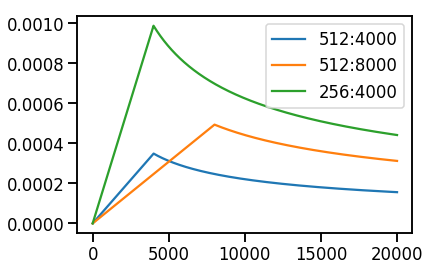

In [57]:
opts=[NoamOpt(512,0.5,4000,None),
     NoamOpt(512,1,8000,None),
     NoamOpt(256,1,4000,None)]
plt.plot(np.arange(1,20000),[[opt.rate(i) for opt in opts] for i in range(1,20000)])
plt.legend(["512:4000","512:8000","256:4000"])

In [172]:
class LabelSmoothing(nn.Module):
    def __init__(self,size,padding_idx,smoothing=0.0):
        super(LabelSmoothing,self).__init__()
        self.criterion=nn.KLDivLoss(size_average=False)
        self.padding_idx=padding_idx
        self.confidence=1.0-smoothing
        self.smoothing=smoothing
        self.size=size
        self.true_dist=None
    def forward(self,x,target):
        assert x.size(1)==self.size
        true_dist=x.data.clone()
        true_dist.fill_(self.smoothing/(self.size-2))
        # scatter_ 按照index的维度将对应位置的数据填充到指定tensor中，target.dim()>=source.dim()
        true_dist.scatter_(1,target.data.unsqueeze(1),self.confidence)
        true_dist[:,self.padding_idx]=0
        mask=torch.nonzero(target.data==self.padding_idx)
#         print(mask,target.data==self.padding_idx)
        if mask.dim()>1:
            # 获得mask对其进行mask
            true_dist.index_fill_(0,mask.squeeze(),0.0)
        self.true_dist=true_dist
        return self.criterion(x,Variable(true_dist,requires_grad=False))
    

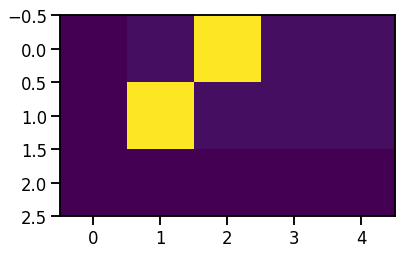

In [173]:
crit=LabelSmoothing(5,0,0.1)
predict = torch.FloatTensor([[0,2,0.7,0.1,0],
                            [0,0.2,0.7,0.1,0],
                            [0,0.2,0.7,0.1,0]])
x=predict.log()
v=crit(Variable(x),Variable(torch.LongTensor([2,1,0])))
plt.imshow(crit.true_dist)


/Users/user/.virtualenvs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys


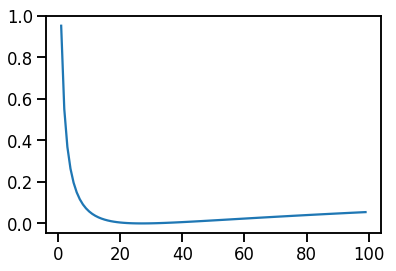

In [174]:
crit = LabelSmoothing(5, 0, 0.1)
def loss(x):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d]])
    #print(predict)
    return crit(Variable(predict.log()),
                 Variable(torch.LongTensor([1]))).data[0]
plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])


In [176]:
!pip install torchtext spacy
!python -m spacy download en
!python -m spacy download de

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
    100% |████████████████████████████████| 71kB 1.5MB/s ta 0:00:011
    100% |████████████████████████████████| 31.3MB 10.8MB/s ta 0:00:01    43% |██████████████                  | 13.6MB 5.8MB/s eta 0:00:04    46% |███████████████                 | 14.6MB 5.7MB/s eta 0:00:03
    100% |████████████████████████████████| 3.0MB 4.8MB/s ta 0:00:011
    100% |████████████████████████████████| 276kB 4.1MB/s ta 0:00:01
    100% |████████████████████████████████| 61kB 1.5MB/s ta 0:00:01
    100% |████████████████████████████████| 2.9MB 4.4MB/s ta 0:00:011
    100% |████████████████████████████████| 153kB 1.1MB/s ta 0:00:01
You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Looking in indexes: http://mirrors.aliyun.com/pypi/simple
    100% |████████████████████████████████| 11.1MB 5.1MB/s ta 0:00:01
  Running setup.py install for en-core-web-sm 

In [178]:
from torchtext import data,datasets
import spacy
spacy_de=spacy.load('de')
spacy_en=spacy.load('en')
def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)]
def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]
BOS_WORD='<s>'
EOS_WORD='</s>'
BLANK_WORD='<blank>'
SRC=data.Field(tokenize=tokenize_de,pad_token=BLANK_WORD)
TGT=data.Field(tokenize=tokenize_en,init_token=BOS_WORD,eos_token=EOS_WORD,pad_token=BLANK_WORD)
MAX_LEN=100
train,val,test=datasets.IWSLT.splits(
    exts=('.de','.en'),fields=(SRC,TGT),
    filter_pred=lambda x:len(vars(x)['src']) <= MAX_LEN and 
    len(vars(x)['trg'])<=MAX_LEN
)
MIN_FREQ=2
SRC.build_vocab(train.src,min_freq=MIN_FREQ)
TGT.build_vocab(train.tgt,min_freq=MIN_FREQ)

downloading de-en.tgz


de-en.tgz: 100%|██████████| 24.2M/24.2M [01:19<00:00, 305kB/s] 


.data/iwslt/de-en/IWSLT16.TEDX.tst2013.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TEDX.tst2014.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TEDX.dev2012.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.tst2011.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.tst2013.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.tst2014.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.dev2010.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.tst2010.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.tst2012.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.tst2010.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.tst2012.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.tst2011.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.tst2013.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.tst2014.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.dev2010.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TEDX.tst2013.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TEDX.tst2014.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TEDX.dev2012.de-en.en.xml
.data/iwslt/de-en/train.tags.de-en.en
.data/iwslt/de-en/train.tags.de-en.de


In [183]:
class MyIterator(data.Iterator):
    def create_batches(self):
        if self.train:
            def pool(d,random_shuffler):
                for p in data.batch(d,self.batch_size*100):
                    p_batch = data.batch(
                        sorted(p,key=self.sort_key),
                        self.batch_size,
                        self.batch_size_fn
                    )
                    for b in random_shuffler(list(p_batch)):
                        yield b
            self.batches=pool(self.data(),self.random_shuffler)
        else:
            self.batches=[]
            for b in data.batch(self.data(),self.batch_size,self.batch_size_fn):
                self.batches.append(sorted(b,key=self.sort_key))
def rebatch(pad_idx,batch):
    src,tgt=batch.src.transpose(0,1),batch.trg.transpose(0,1)
    return Batch(src,tgt,pad_idx)